In [1]:
# Only run once, unless restarting kernel
import os
os.chdir('../')
print(os.getcwd())  # Should output the project folder

/home/vlad/Desktop/lmu_bachelor_thesis/code/VariationalInformationPursuit


In [2]:
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from mutagenicity_dataset import *
# from feature_engineering.node_features import *

/home/vlad/anaconda3/envs/vip_graphs/lib/python3.12/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1729805341246/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


In [3]:
### LOAD DATASET ###
data_path = './data'
transform = get_combined_mapping_transform()
dataset = TUDataset(root=data_path, name='Mutagenicity', transform=transform)

In [4]:
### CONVERT TO NETWORKX ###
dataset_nx = []
for data in tqdm(dataset):
    G = to_networkx(data, to_undirected=True, edge_attrs=['bonds'], node_attrs=['atom'])
    dataset_nx.append(G)
dataset_nx = np.array(dataset_nx, dtype=nx.classes.graph.Graph)

100%|██████████| 4337/4337 [00:01<00:00, 3569.12it/s]


In [134]:
from rdkit import Chem
from rdkit.Chem import Draw


def nx_to_rdkit(G):
    """
    Convert a NetworkX graph G to an RDKit molecule.
    
    Assumes:
      - Each node has an attribute "atom" that contains the element symbol (e.g., "C", "O", etc.)
      - Each edge has an attribute "bond" that is an integer (1, 2, or 3) representing the bond order.
    """
    # Create an editable RDKit molecule
    rwmol = Chem.RWMol()
    
    # Map NetworkX nodes to RDKit atom indices
    node_to_idx = {}
    for node, data in G.nodes(data=True):
        atom_symbol = data.get('atom')
        if atom_symbol is None:
            raise ValueError(f'Node {node} does not have an \'atom\' attribute')
        atom = Chem.Atom(atom_symbol)
        idx = rwmol.AddAtom(atom)
        node_to_idx[node] = idx

    # Add bonds between atoms
    for u, v, data in G.edges(data=True):
        bond_order = data.get('bonds')
        if bond_order is None:
            raise ValueError(f'Edge ({u}, {v}) does not have a \'bonds\' attribute')
        if bond_order == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
        elif bond_order == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
        elif bond_order == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
        else:
            raise ValueError(f'Unsupported bond order {bond_order} on edge ({u}, {v})')
        
        # Add the bond using the mapped indices
        rwmol.AddBond(node_to_idx[u], node_to_idx[v], bond_type)

    # Check if the atom is nitrogen with 4 bonds, and if it is, give it formal charge +1
    for atom in rwmol.GetAtoms():
        if atom.GetSymbol() == 'N':
            total_bonds = sum([bond.GetBondTypeAsDouble() for bond in atom.GetBonds()])
            if total_bonds == 4:  # Overbonded N atom
                atom.SetFormalCharge(1)
    
    # Check if the atom is oxygen with 3 bonds, and if it is, give it formal charge +1
    for atom in rwmol.GetAtoms():
        if atom.GetSymbol() == 'O':
            total_bonds = sum([bond.GetBondTypeAsDouble() for bond in atom.GetBonds()])
            if total_bonds == 3:  # Overbonded oxygen
                atom.SetFormalCharge(1)


    # Convert to a standard RDKit Mol object
    mol = rwmol.GetMol()
    
    # Sanitize the molecule (this checks valences, computes aromaticity, etc.)
    Chem.SanitizeMol(mol)
    return mol

If we sanitize the mol, data at idx 600 gives error (4 bonds from N when only 3 are permitted)

In [106]:
problematic

[1125, 2095, 3484]

[H]OC(=O)c1c([H])c([H])c([H])c([H])c1-c1c2c([H])c([H])c(N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])c([H])c2[o+]c2c([H])c(N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])c([H])c([H])c12


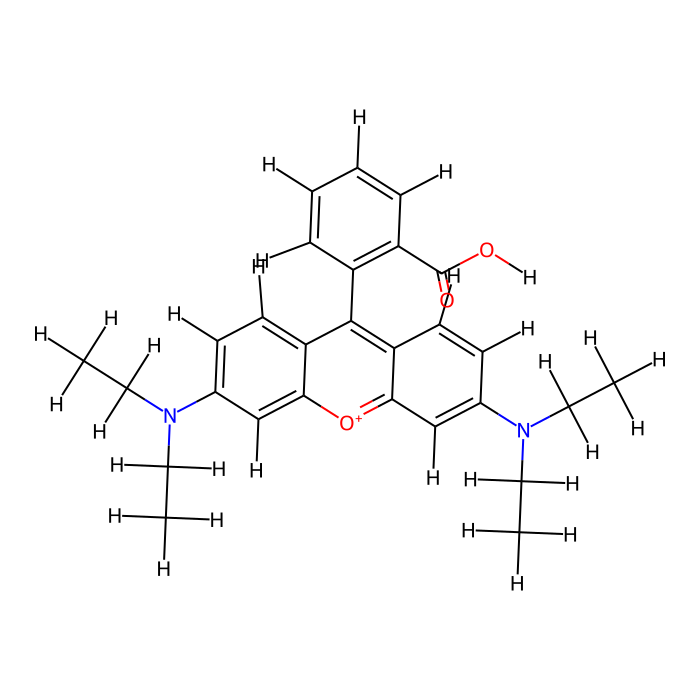

In [136]:
G = dataset_nx[3484]
mol = nx_to_rdkit(G)
print(Chem.MolToSmiles(mol))
img = Draw.MolToImage(mol, size=(700,700))
img

In [191]:
for atom in mol.GetAtoms():
    if atom.GetSymbol() == 'O' and atom.GetFormalCharge() == 1:
        print(f"Quaternary ammonium detected on atom {atom.GetIdx()}.")

Quaternary ammonium detected on atom 16.


[(0, 1, {'bonds': 2}), (0, 2, {'bonds': 1}), (0, 3, {'bonds': 1}), (2, 33, {'bonds': 1}), (3, 4, {'bonds': 2}), (3, 5, {'bonds': 1}), (4, 6, {'bonds': 1}), (4, 7, {'bonds': 1}), (5, 8, {'bonds': 2}), (5, 34, {'bonds': 1}), (6, 9, {'bonds': 2}), (6, 10, {'bonds': 1}), (7, 11, {'bonds': 2}), (7, 35, {'bonds': 1}), (8, 11, {'bonds': 1}), (8, 36, {'bonds': 1}), (9, 12, {'bonds': 1}), (9, 13, {'bonds': 1}), (10, 14, {'bonds': 2}), (10, 15, {'bonds': 1}), (11, 37, {'bonds': 1}), (12, 16, {'bonds': 2}), (12, 17, {'bonds': 1}), (13, 18, {'bonds': 2}), (13, 38, {'bonds': 1}), (14, 16, {'bonds': 1}), (14, 19, {'bonds': 1}), (15, 20, {'bonds': 2}), (15, 39, {'bonds': 1}), (17, 21, {'bonds': 2}), (17, 40, {'bonds': 1}), (18, 21, {'bonds': 1}), (18, 41, {'bonds': 1}), (19, 22, {'bonds': 2}), (19, 42, {'bonds': 1}), (20, 22, {'bonds': 1}), (20, 43, {'bonds': 1}), (21, 23, {'bonds': 1}), (22, 24, {'bonds': 1}), (23, 25, {'bonds': 1}), (23, 26, {'bonds': 1}), (24, 27, {'bonds': 1}), (24, 28, {'bonds':

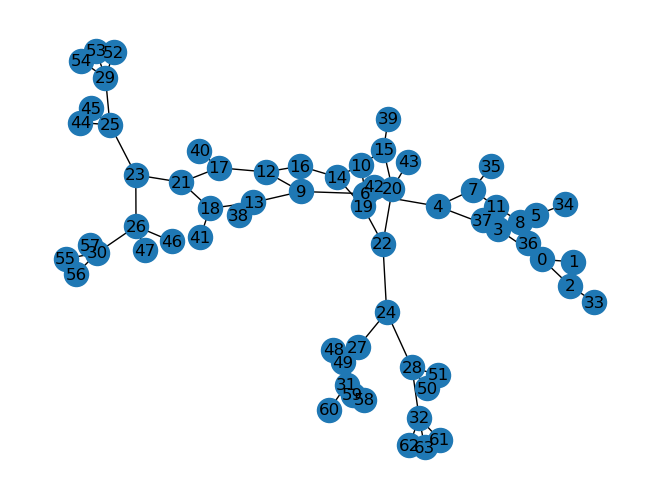

In [192]:
print(G.edges(data=True))
print(G.nodes(data=True))
nx.draw(G, with_labels=True)

These N atoms with 4 bonds could be N atoms with 3 bonds but that have positive formal charge of 1. Make note of this. I wasn't able to find information about this in the paper that describes the dataset though.

Let's try checking for functional groups now:

In [195]:
from rdkit.Chem import Fragments

fr_alkyl_halide: 1
fr_halogen: 1


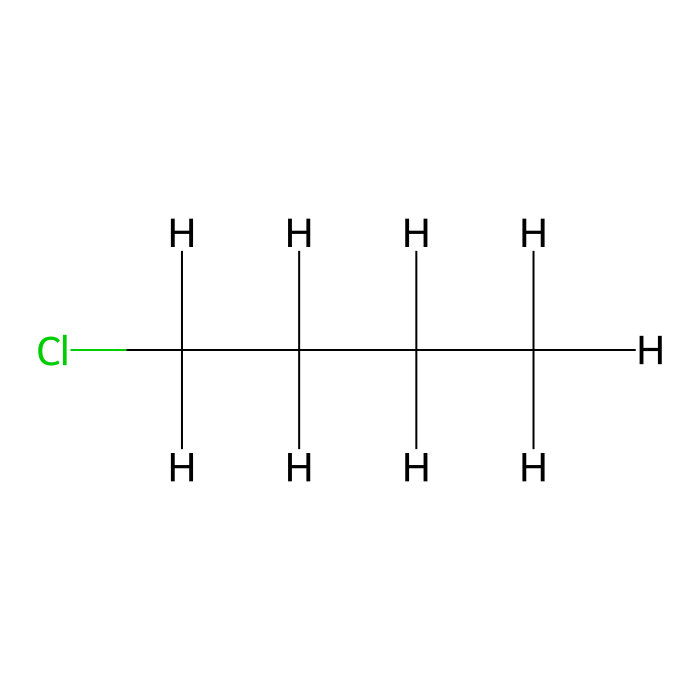

In [276]:
def apply_all_fragments_dynamic(mol, count_unique):
    # Discover all fragment-checking functions in the module (Should be 85)
    fragment_funcs = [func for func in dir(Fragments) if func.startswith('fr_') and callable(getattr(Fragments, func))]

    results = {}
    
    # Apply each function to the molecule
    for func_name in fragment_funcs:
        func = getattr(Fragments, func_name)
        try:
            result = func(mol, count_unique)  # When is appropriate to use count_unique=False?
            results[func_name] = result
        except Exception as e:
            results[func_name] = f"Error: {str(e)}"
    
    return results

# Example: Applying to a simple molecule (ethanol)
G = dataset_nx[1000]
mol = nx_to_rdkit(G)
results = apply_all_fragments_dynamic(mol, count_unique=False)

results

# Display results
for fragment, count in results.items():
    if count > 0:
        print(f"{fragment}: {count}")

img = Draw.MolToImage(mol, size=(700, 700))
img

Now calculate for the entire dataset.

In [240]:
datasubset_nx = dataset_nx
frag_counts = []
for G in tqdm(datasubset_nx):
    mol = nx_to_rdkit(G)
    frag_counts.append(apply_all_fragments_dynamic(mol))

100%|██████████| 4337/4337 [00:02<00:00, 2031.55it/s]


In [241]:
len(frag_counts)

4337

Seems to work super fast. Let's see what the frag counts look like for our dataset, and get an idea of how to define our queries (i.e. for what counts should we create queries?).

In [253]:
# Initialize dict
frag_names = frag_counts[0].keys()
frag_dict = {}
frag_total = {}
for name in frag_names:
    frag_dict[name] = []
    frag_total[name] = 0

# Get counts
for count_dict in frag_counts:
    for name in frag_names:
        frag_dict[name] = frag_dict[name] + [count_dict[name]]
        frag_total[name] = frag_total[name] + count_dict[name]

In [254]:
frag_total

{'fr_Al_COO': 359,
 'fr_Al_OH': 1106,
 'fr_Al_OH_noTert': 148,
 'fr_ArN': 698,
 'fr_Ar_COO': 100,
 'fr_Ar_N': 1542,
 'fr_Ar_NH': 228,
 'fr_Ar_OH': 732,
 'fr_COO': 459,
 'fr_COO2': 472,
 'fr_C_O': 2538,
 'fr_C_O_noCOO': 2080,
 'fr_C_S': 26,
 'fr_HOCCN': 23,
 'fr_Imine': 40,
 'fr_NH0': 3692,
 'fr_NH1': 1244,
 'fr_NH2': 999,
 'fr_N_O': 66,
 'fr_Ndealkylation1': 149,
 'fr_Ndealkylation2': 37,
 'fr_Nhpyrrole': 228,
 'fr_SH': 30,
 'fr_aldehyde': 116,
 'fr_alkyl_carbamate': 7,
 'fr_alkyl_halide': 756,
 'fr_allylic_oxid': 864,
 'fr_amide': 853,
 'fr_amidine': 23,
 'fr_aniline': 1394,
 'fr_aryl_methyl': 471,
 'fr_azide': 0,
 'fr_azo': 149,
 'fr_barbitur': 2,
 'fr_benzene': 5461,
 'fr_benzodiazepine': 5,
 'fr_bicyclic': 4424,
 'fr_diazo': 3,
 'fr_dihydropyridine': 4,
 'fr_epoxide': 216,
 'fr_ester': 533,
 'fr_ether': 1992,
 'fr_furan': 112,
 'fr_guanido': 19,
 'fr_halogen': 1874,
 'fr_hdrzine': 63,
 'fr_hdrzone': 22,
 'fr_imidazole': 181,
 'fr_imide': 47,
 'fr_isocyan': 8,
 'fr_isothiocyan': 6,


In [262]:
# Find min and max counts of a fragment
min_max_dict = {}
for key, val in frag_dict.items():
    min_max_dict[key] = (min(val), max(val))
min_max_dict

{'fr_Al_COO': (0, 4),
 'fr_Al_OH': (0, 14),
 'fr_Al_OH_noTert': (0, 9),
 'fr_ArN': (0, 5),
 'fr_Ar_COO': (0, 2),
 'fr_Ar_N': (0, 6),
 'fr_Ar_NH': (0, 3),
 'fr_Ar_OH': (0, 6),
 'fr_COO': (0, 4),
 'fr_COO2': (0, 4),
 'fr_C_O': (0, 14),
 'fr_C_O_noCOO': (0, 13),
 'fr_C_S': (0, 2),
 'fr_HOCCN': (0, 3),
 'fr_Imine': (0, 2),
 'fr_NH0': (0, 8),
 'fr_NH1': (0, 15),
 'fr_NH2': (0, 6),
 'fr_N_O': (0, 3),
 'fr_Ndealkylation1': (0, 4),
 'fr_Ndealkylation2': (0, 1),
 'fr_Nhpyrrole': (0, 3),
 'fr_SH': (0, 2),
 'fr_aldehyde': (0, 2),
 'fr_alkyl_carbamate': (0, 2),
 'fr_alkyl_halide': (0, 19),
 'fr_allylic_oxid': (0, 26),
 'fr_amide': (0, 13),
 'fr_amidine': (0, 2),
 'fr_aniline': (0, 10),
 'fr_aryl_methyl': (0, 5),
 'fr_azide': (0, 0),
 'fr_azo': (0, 4),
 'fr_barbitur': (0, 1),
 'fr_benzene': (0, 8),
 'fr_benzodiazepine': (0, 1),
 'fr_bicyclic': (0, 12),
 'fr_diazo': (0, 1),
 'fr_dihydropyridine': (0, 1),
 'fr_epoxide': (0, 3),
 'fr_ester': (0, 5),
 'fr_ether': (0, 14),
 'fr_furan': (0, 2),
 'fr_guan

Let's actually see how many queries would be in our query set!

In [264]:
query_num_dict = {}
for key, val in min_max_dict.items():
    query_num_dict[key] = val[1] - val[0] + 1  # Include asking "Are there zero of frag x in the mol" as a query
query_num_dict

{'fr_Al_COO': 5,
 'fr_Al_OH': 15,
 'fr_Al_OH_noTert': 10,
 'fr_ArN': 6,
 'fr_Ar_COO': 3,
 'fr_Ar_N': 7,
 'fr_Ar_NH': 4,
 'fr_Ar_OH': 7,
 'fr_COO': 5,
 'fr_COO2': 5,
 'fr_C_O': 15,
 'fr_C_O_noCOO': 14,
 'fr_C_S': 3,
 'fr_HOCCN': 4,
 'fr_Imine': 3,
 'fr_NH0': 9,
 'fr_NH1': 16,
 'fr_NH2': 7,
 'fr_N_O': 4,
 'fr_Ndealkylation1': 5,
 'fr_Ndealkylation2': 2,
 'fr_Nhpyrrole': 4,
 'fr_SH': 3,
 'fr_aldehyde': 3,
 'fr_alkyl_carbamate': 3,
 'fr_alkyl_halide': 20,
 'fr_allylic_oxid': 27,
 'fr_amide': 14,
 'fr_amidine': 3,
 'fr_aniline': 11,
 'fr_aryl_methyl': 6,
 'fr_azide': 1,
 'fr_azo': 5,
 'fr_barbitur': 2,
 'fr_benzene': 9,
 'fr_benzodiazepine': 2,
 'fr_bicyclic': 13,
 'fr_diazo': 2,
 'fr_dihydropyridine': 2,
 'fr_epoxide': 4,
 'fr_ester': 6,
 'fr_ether': 15,
 'fr_furan': 3,
 'fr_guanido': 3,
 'fr_halogen': 20,
 'fr_hdrzine': 3,
 'fr_hdrzone': 3,
 'fr_imidazole': 3,
 'fr_imide': 3,
 'fr_isocyan': 3,
 'fr_isothiocyan': 2,
 'fr_ketone': 5,
 'fr_ketone_Topliss': 5,
 'fr_lactam': 2,
 'fr_lactone': 

In [266]:
# Total number of queries
total_queries = 0
for _, val in query_num_dict.items():
    total_queries += val
print(total_queries)

475
